In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the CTR data for A/B Test

In [3]:
df_ab_test = pd.read_csv('ad_click_dataset.csv')

### EDA

In [4]:
df_ab_test

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
...,...,...,...,...,...,...,...,...,...
9995,8510,User8510,NaN,NaN,Mobile,Top,Education,NaN,0
9996,7843,User7843,NaN,Female,Desktop,Bottom,Entertainment,NaN,0
9997,3914,User3914,NaN,Male,Mobile,Side,NaN,Morning,0
9998,7924,User7924,NaN,NaN,Desktop,NaN,Shopping,Morning,1


In [5]:
df_ab_test.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


In [6]:
df_ab_test.describe()

,id,age,click
count,10000.000000,5234.000000,10000.000000
mean,5060.211400,40.197363,0.650000
std,2861.758265,13.126420,0.476993
min,5.000000,18.000000,0.000000
25%,2529.000000,29.000000,0.000000
50%,5218.000000,39.500000,1.000000
75%,7466.000000,52.000000,1.000000
max,10000.000000,64.000000,1.000000


In [7]:
df_ab_test.groupby("time_of_day").sum("click")

,id,age,click
time_of_day,,,
Afternoon,10523567,42071.0,1382
Evening,9555097,40097.0,1233
Morning,10903539,45162.0,1414
Night,9657668,41425.0,1187


In [8]:
df_ab_test.groupby("ad_position").sum("click")

,id,age,click
ad_position,,,
Bottom,13658598,57794.0,1936
Side,13665886,56515.0,1633
Top,13199343,53966.0,1649


A simple bar chart showing the total clicks versus no-clicks in each group (device_type) can provide a clear visual comparison of user engagement

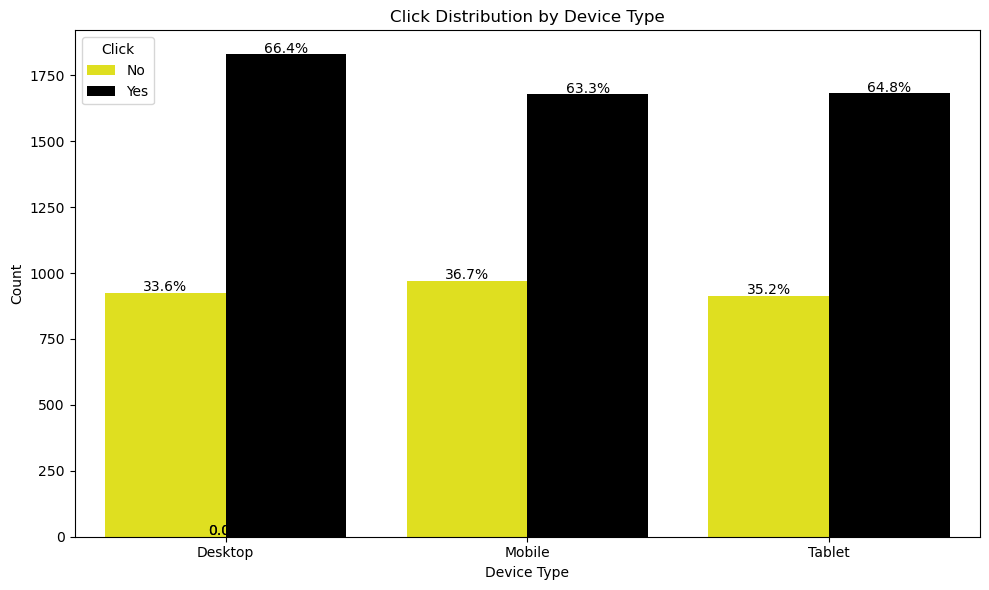

In [9]:
# Custom palette for no-click and click
palette = {0: 'yellow', 1: 'black'}

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='device_type', hue='click', data=df_ab_test, palette=palette)
plt.title('Click Distribution by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.legend(title='Click', labels=['No', 'Yes'])

# Calculate totals
group_counts = df_ab_test.groupby(['device_type']).size()

# Get tick positions and labels
xticks = ax.get_xticks()
xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

for p in ax.patches:
    height = p.get_height()
    bar_x = p.get_x() + p.get_width() / 2

    # Find the closest tick to the bar_x
    distances = [abs(bar_x - tick) for tick in xticks]
    closest_index = np.argmin(distances)
    ad_position = xticklabels[closest_index]

    total = group_counts.loc[ad_position]
    percentage = 100 * height / total

    ax.text(
        bar_x,
        height + 5,
        f'{percentage:.1f}%',
        ha='center',
        color='black',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [10]:
# Checking if any columns in the dataset have nulls

df_ab_test.isnull().sum()

id                     0
full_name              0
age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64

In [11]:
# Number of rows in the dataset

df_ab_test.shape[0]

10000

In [12]:
# Looking at records where device_type IS NULL

df_ab_test[df_ab_test['device_type'].isnull()]

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
5,5942,User5942,NaN,Non-Binary,NaN,Bottom,Social Media,Evening,1
9,4509,User4509,NaN,NaN,NaN,Bottom,Education,Afternoon,1
...,...,...,...,...,...,...,...,...,...
9979,8337,User8337,NaN,Female,NaN,Bottom,Entertainment,Night,0
9984,9422,User9422,21.0,NaN,NaN,Side,Entertainment,Night,1
9990,9540,User9540,64.0,Non-Binary,NaN,Side,Education,NaN,0
9993,503,User503,43.0,NaN,NaN,NaN,NaN,Morning,1


In [13]:
df_ab_test.groupby('device_type', dropna=False)[['id']].count()

,id
device_type,
Desktop,2754
Mobile,2649
Tablet,2597
NaN,2000


### Cleaning the dataset

In [21]:
# Dropping rows where device_type is null

df_ab_test.dropna(subset=['device_type'], axis=0, inplace=True)

df_ab_test

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click,group
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1,group_A
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1,group_A
6,7808,User7808,26.0,Female,Desktop,Top,NaN,NaN,1,group_A
7,5065,User5065,40.0,Male,Mobile,Side,NaN,Evening,0,group_B
8,7993,User7993,NaN,Non-Binary,Mobile,Bottom,Social Media,NaN,1,group_B
...,...,...,...,...,...,...,...,...,...,...
9995,8510,User8510,NaN,NaN,Mobile,Top,Education,NaN,0,group_B
9996,7843,User7843,NaN,Female,Desktop,Bottom,Entertainment,NaN,0,group_A
9997,3914,User3914,NaN,Male,Mobile,Side,NaN,Morning,0,group_B
9998,7924,User7924,NaN,NaN,Desktop,NaN,Shopping,Morning,1,group_A


In [15]:
# Create a group column to identify groups by device_type

df_ab_test['group'] = None # or '', or dtype='object'

# Assign Desktop to group A, and Mobile to group B

df_ab_test.loc[df_ab_test['device_type'] == 'Desktop', 'group'] = 'group_A'
df_ab_test.loc[df_ab_test['device_type'] == 'Mobile', 'group'] = 'group_B'

df_ab_test

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click,group
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1,group_A
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1,group_A
6,7808,User7808,26.0,Female,Desktop,Top,NaN,NaN,1,group_A
7,5065,User5065,40.0,Male,Mobile,Side,NaN,Evening,0,group_B
8,7993,User7993,NaN,Non-Binary,Mobile,Bottom,Social Media,NaN,1,group_B
...,...,...,...,...,...,...,...,...,...,...
9995,8510,User8510,NaN,NaN,Mobile,Top,Education,NaN,0,group_B
9996,7843,User7843,NaN,Female,Desktop,Bottom,Entertainment,NaN,0,group_A
9997,3914,User3914,NaN,Male,Mobile,Side,NaN,Morning,0,group_B
9998,7924,User7924,NaN,NaN,Desktop,NaN,Shopping,Morning,1,group_A


### Calculating CTR for each group

In [16]:
# Calculating the total impressions per group

N_con = df_ab_test[df_ab_test["group"] == "group_A"].shape[0]
N_exp = df_ab_test[df_ab_test["group"] == "group_B"].shape[0]

# Printing total impressions per group

print(f"Total impressions for group A (control group): {N_con}")
print(f"Total impressions for group B (experimental group): {N_exp}")

Total impressions for group A (control group): 2754
Total impressions for group B (experimental group): 2649


In [17]:
# Calculating the total number of clicks per group by summing 1's

X_con = df_ab_test.groupby("group")["click"].sum().loc["group_A"]
X_exp = df_ab_test.groupby("group")["click"].sum().loc["group_B"]

# Printing total clicks per group

print(f"Total clicks for group A (control group): {X_con}")
print(f"Total clicks for group B (experimental group): {X_exp}")

Total clicks for group A (control group): 1829
Total clicks for group B (experimental group): 1678


In [18]:
# Calculating CTR per group

p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp

# Printing CTR per group

print(f"The CTR of group_A (control group): {p_con_hat}")
print(f"The CTR of group_B (experimental group): {p_exp_hat}")


The CTR of group_A (control group): 0.6641249092229484
The CTR of group_B (experimental group): 0.633446583616459


In [19]:
# Computing the estimate of pooled click probability (value that describes the control and experimental group)

p_pooled_hat = (X_con + X_exp)/(N_con + N_exp)

print(f"The pooled click probability is {p_pooled_hat}")

The pooled click probability is 0.6490838423098279


### Calculating Pooled Variance

In [22]:
# Computing the estimate of pooled variance

pooled_variance = p_pooled_hat * (1 - p_pooled_hat) * (1/N_con + 1/N_exp)

print(f"p^_pooled is {p_pooled_hat}")
print(f"Pooled variance is {pooled_variance}")

p^_pooled is 0.6490838423098279
Pooled variance is 0.0001686915144284361


### Calculating Standard Error and Test Statistics

In [23]:
# Computing standard error of the test

SE = np.sqrt(pooled_variance)

print(f"The standard error is {SE}")



The standard error is 0.012988129750985556
